# Different more flexible LSTM from [here](https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7)

In [17]:
import math
import csv
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
N = 100 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

In [51]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)

        
    def forward(self, y, future_preds=0):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs


In [52]:
train_input = torch.from_numpy(y[3:, :-1]) # (97, 999)
train_target = torch.from_numpy(y[3:, 1:]) # (97, 999)

In [53]:
test_input = torch.from_numpy(y[:3, :-1]) # (3, 999)
test_target = torch.from_numpy(y[:3, 1:]) # (3, 999)

Text(0.5, 1.0, 'Random Plot of x data')

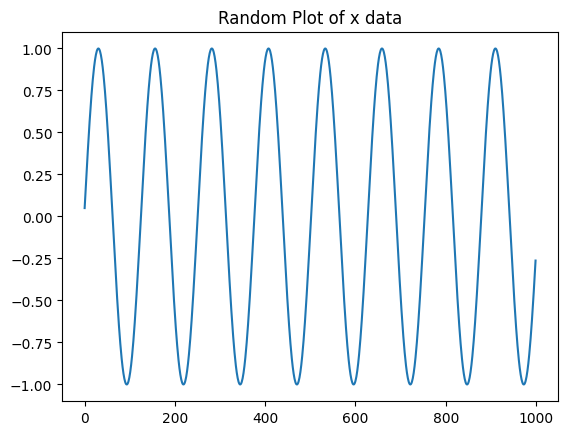

In [59]:
plt.plot(y[5,:])
plt.title('Random Plot of x data')

Text(0.5, 1.0, 'Random Plot of x data')

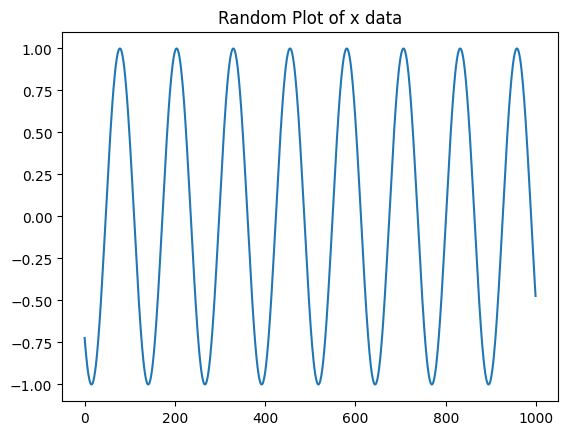

In [60]:
plt.plot(y[19,:])
plt.title('Random Plot of x data')

In [55]:
def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input)
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        with torch.no_grad():
            future = 1000
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.savefig("predict%d.png"%i, dpi=200)
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [56]:
training_loop(10, model, optimiser, criterion,train_input, train_target, test_input, test_target)

Step: 0, Loss: 0.024521466344594955
Step: 1, Loss: 0.015422922559082508
Step: 2, Loss: 0.0010728052584454417
Step: 3, Loss: 0.0008887571166269481
Step: 4, Loss: 0.0008236799039877951
Step: 5, Loss: 0.0005274828290566802
Step: 6, Loss: 0.00033209158573299646
Step: 7, Loss: 0.0002311006683157757
Step: 8, Loss: 0.00020325217337813228
Step: 9, Loss: 0.00013367297651711851


## Conclusion
So this model actually learns what is a sinusoid function. Then it can predict the next values. If the curves for PD and control group are different enough, maybe it is possible to make a similar model for classification, by adding addtional layers to a pre-trained on the prediction model? 

However, the plots of our data show that the function is much more complex, so it can be less trivial to make LSTM to learn it. 